# General data reader for AQUA 

The idea of this AQUA reader draft is to provide a first common access point to data in order to quickly develop diagnostics. 

For now access is through intake catalogues of NextGEMS data and it works on Levante, but the idea is to extend this to FDB access and other datasources in the future.

It includes also regridding functionality. The idea of the regridder (which uses sparse matrix multiplication) is to generate first the weights for the interpolation (an operation which needs to be done only once) and then to use them for each regridding operation.

Further, the reader includes a simple 'data fixer', that is the capability to edit the metadata of the input datasets fixing variable or coordinate names and performing unit conversions. 

For regridding to work you will need the external [smmregrid](https://github.com/jhardenberg/smmregrid) module in your environment.

The following notebooks illustrate more in detail different aspects of the functionality of the reader:

1. [Regridding](regrid.ipynb)
2. [Coordinate, variable name, units fixer](fixer.ipynb)
2. [Temporal averaging](timmean.ipynb)
3. [Spatial (field) averaging](fldmean.ipynb)
4. [Other datasets](datasets.ipynb)
5. [Streaming](streaming.ipynb)

## Basic functionality

In a nutshell, how to load ICON data, regrid them to a regular grid and plot a timeseries.

We start loading the module

In [1]:
import sys
sys.path.append("../..")  # hack to import module -- to be removed later

from aqua import Reader, catalogue

Now let's load some ICON data. We first instantiate a `Reader` object specifying the type of data which we want to read from the catalogue. 
We also specify that we would like to regrid to a 0.1°x0.1° grid.
The first time (only then) when you run it, it will compute regridding weights for this particular source/destination grid combination. These will be stored in a directory specified in the `config/regrid.yaml` file.

In [10]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid='r010')

Later  the actual data can be read with the `retrieve` method.

In [11]:
data = reader.retrieve()

No fixes defined for model  ICON


The reader returns an xarray.Dataset with raw ICON data on the original grid

In [12]:
data

<xarray.Dataset>
Dimensions:   (time: 37009, cell: 20971520)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
Dimensions without coordinates: cell
Data variables: (12/34)
    cfh_lnd   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    clivi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cllvi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cptgzvi   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfls      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfss      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ...        ...
    tas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauu      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauv      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ts        (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    uas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    vas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 152214
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

Let's inspect the "tas" variable (in a DataArray)

In [13]:
data.tas

<xarray.DataArray 'tas' (time: 37009, cell: 20971520)>
dask.array<open_dataset-9142e691bdca8a31a6d962c1925ca64dtas, shape=(37009, 20971520), dtype=float32, chunksize=(6, 1048576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T00:30:00 ... 2022-03-01
Dimensions without coordinates: cell
Attributes:
    CDI_grid_type:                unstructured
    cell_methods:                 t: point
    height:                       2.0 m
    long_name:                    temperature in 2m
    number_of_grid_in_reference:  1
    param:                        0.0.0
    standard_name:                tas
    units:                        K

Notice that these data are still on the original (irregular) grid. We can regrid (part of) them with

In [16]:
tasr = reader.regrid(data.tas[10, :])
tasr

<xarray.DataArray 'tas' (lat: 1800, lon: 3600)>
dask.array<reshape, shape=(1800, 3600), dtype=float64, chunksize=(1800, 3600), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-01-20T05:00:00
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
Attributes:
    CDI_grid_type:                unstructured
    cell_methods:                 t: point
    height:                       2.0 m
    long_name:                    temperature in 2m
    number_of_grid_in_reference:  1
    param:                        0.0.0
    standard_name:                tas
    units:                        K
    regridded:                    1

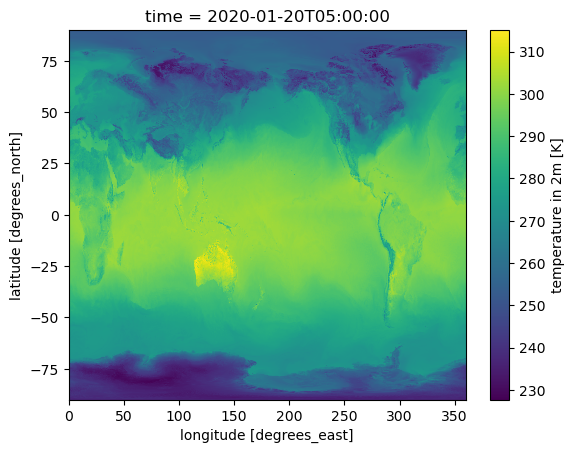

In [17]:
tasr.plot()

We can also plot a timeseries using the `fldmean` method.

(100, 20971520)


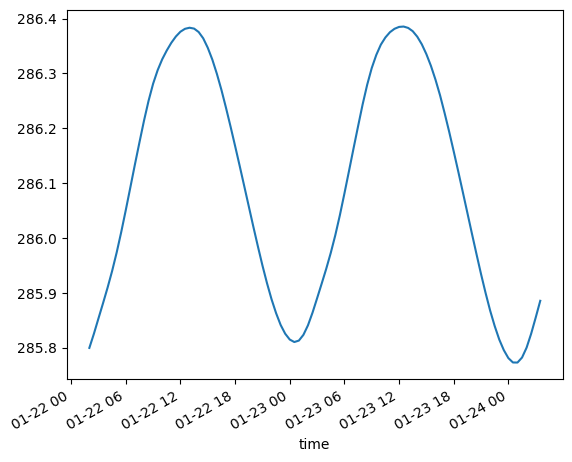

In [22]:
global_mean = reader.fldmean(data.tas[100:200, :])
global_mean.plot()

## Extra notes

### Dask

It is convenient to start a Dask cluster first (unless you already are working in a Levante jupyter notebook) and to connect to it

In [2]:
from dask.distributed import LocalCluster, Client, progress
cluster = LocalCluster(ip="0.0.0.0", threads_per_worker=2, n_workers=16)
client = Client(cluster)  # memory_limit='64GB'
cluster

LocalCluster(e8e73934, 'tcp://136.172.124.2:38023', workers=16, threads=32, memory=503.45 GiB)

### Catalogue

In order to check what is available in the catalogue there is the `catalogue()` function. It returns the catalogue itself by default, that's why we use it with a semicolon at the end.

In [2]:
catalogue();

../../config
IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	
	- interpolated_global	
	- interpolated_np	
	- interpolated_sp	
	- interpolated_sp_ci	
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	
	- interpolated_global	
	- interpolated_np	
	- interpolated_sp	
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	

FESOM	tco3999-ng5	2.5km experiment, coupuled with IFS
	- elem_grid	
	- node_grid	
	- np	nearest-neighbor interpolation to lat-lon grid
	- interpolated_global2d	
	- interpolated_global_TS	
	- interpolated_global_UV	
	- interpolated_np	
	- interpolated_sp	
	- original_2d	original 2d output
	- original_3d	original 3d output
FESOM	tco2559-ng5	5km experiment, coupuled with IFS
	- elem_grid	
	- node_grid	
	- interpolated_global2d	
	- interpolated_global_TS	
	- interpolated_global_UV	
	- interpolated_np	
	- interpolated_sp	
	- ori

/home/b/b382075/mambaforge/envs/aqua2/lib/python3.10/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


	- monthly_inst	ERA5 instantaneous 2D data monthly averaged


/home/b/b382075/mambaforge/envs/aqua2/lib/python3.10/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


	- monthly_acc	ERA5 accumulated 2D data monthly averaged


/home/b/b382075/mambaforge/envs/aqua2/lib/python3.10/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


	- daily_inst	ERA5 instantaneous 2D data daily


/home/b/b382075/mambaforge/envs/aqua2/lib/python3.10/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


	- daily_acc	ERA5 accumulated 2D data daily



The data are classified in "models" (e.g. ICON, IFS etc.). Each model has a different "experiment" and there are different "sources" for each of them. 

A note on configuration files: by default the reader looks for its config files in a `config` folder in the current directory. If not found also the upper (`..`), the directory above it (`../..`) and the a folder `.aqua/config` in the user's home are explored. In any case it is also possble to pass explicitly a `configdir` keyword to the catalogue and the to the reader.